## Discriminating Between Sonar Signals Bounced Off a Metal Cylinder and Those Bounced Off a Roughly Cylindrical Rock

## Introduction

Sonar is a technique that uses sound propagation characteristics to detect objects by emitting sound pulses and detecting or measuring their return after reflection, used as a means of acoustic location by measuring the echo characteristics of the object. Our project is based on identifying the differences between the sonar returns from an undersea metal cylinder and a cylindrically shaped rock.

In our research we are trying to determine if there is any difference between the Sonar signals bounced off a metal cylinder and those bounced off a cylindrical rock. Thus, the question we will try to answer in our project: Is the object that bounces off a chosen sonar signal a metal cylinder or a cylindrical rock?

The dataset we will use contains signals bounced off a metal cylinder and a roughly cyclindrical rock obtained from a variety of different aspect angles. The angles spanned from 0 to 90 degrees for the metal cylinder and 0 to 180 degrees for the rock. The dataset does not list the explict aspect angles and states that the angles are not equally spaced apart. Thus each of the angles will be named AA_$n$ where $n$ is the $n$th variable. This is to reflect the fact that the angles do not have an explicit degree. The dataset does not list units for the return signal.

## Methods and Results

In this project, we will be using K-nearest neighbor classification algorithm.

First, all the necessary packages were loaded using the library function. Using the read_csv function, the data set was donwloaded from the University of California Irvin's archives.

The set.seed function allows the results to be reproducible.

In [1]:
library(tidyverse)
library(tidymodels)
library(readxl)
library(repr)
library(dplyr)
options(repr.matrix.max.rows = 6)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



ERROR: Error in library(tidymodels): there is no package called ‘tidymodels’


In [2]:
# Read the dataset to sonar
sonar <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data",
                  col_names = FALSE)

# Set seed makes the result reproducible
set.seed(2022)

# Make column names
sonar_column_names <- c()
for (i  in 1:60) {sonar_column_names <- c(sonar_column_names, paste("AA", as.character(i), sep = "_"))}
sonar_column_names <- c(sonar_column_names, "Rocks_or_Mines")
colnames(sonar) <- sonar_column_names

# Convert Rocks_or_Mines into factor since we need to predict classification
sonar <- sonar %>% mutate(Rocks_or_Mines = as_factor(Rocks_or_Mines))
print("Table 1: Sonar Raw Data")
head(sonar)

Rows: 208 Columns: 61
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): X61
dbl (60): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14, X15, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Table 1: Sonar Raw Data"


AA_1,AA_2,AA_3,AA_4,AA_5,AA_6,AA_7,AA_8,AA_9,AA_10,⋯,AA_52,AA_53,AA_54,AA_55,AA_56,AA_57,AA_58,AA_59,AA_60,Rocks_or_Mines
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,⋯,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,⋯,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,⋯,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,⋯,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,⋯,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R
0.0286,0.0453,0.0277,0.0174,0.0384,0.0990,0.1201,0.1833,0.2105,0.3039,⋯,0.0045,0.0014,0.0038,0.0013,0.0089,0.0057,0.0027,0.0051,0.0062,R


In [3]:
# Split data to training data and testing data
sonar_split <- initial_split(sonar, prop = 0.75, strata = Rocks_or_Mines)
sonar_training <- training(sonar_split)
print("Table 2: Sonar Training Dataset")
sonar_training
sonar_testing <- testing(sonar_split)
print("Table 3: Sonar Testing Dataset")
sonar_testing

ERROR: Error in initial_split(sonar, prop = 0.75, strata = Rocks_or_Mines): could not find function "initial_split"


By looking at the data sets, all the columns except Rocks_or_Mines are numerical variables. Rocks_or_Mines is catagorical variable.

### Data Summary

In [13]:
print("Table 4: Observation counts, average values of first five sonar angles for metal and rock objects")
# sonar %>%
# group_by(Rocks_or_Mines) %>%
# # summarize(num_observ = n(), 
# #           AA_1_mean = mean(AA_1), 
# #           AA_2_mean = mean(AA_2), 
# #           AA_3_mean = mean(AA_3), 
# #           AA_4_mean = mean(AA_4), 
# #           AA_5_mean = mean(AA_5))
# summarize(num_observ = n())

sonar_means <- summarise_if(sonar, is.numeric, mean)
    sonar_obs_means <- sonar %>%
    group_by(Rocks_or_Mines) %>%
    summarize(num_observ = n()) %>%
    bind_cols(sonar_means)
    sonar_obs_means

[1] "Table 4: Observation counts, average values of first five sonar angles for metal and rock objects"


`summarise()` ungrouping output (override with `.groups` argument)



Rocks_or_Mines,num_observ,AA_1,AA_2,AA_3,AA_4,AA_5,AA_6,AA_7,AA_8,⋯,AA_51,AA_52,AA_53,AA_54,AA_55,AA_56,AA_57,AA_58,AA_59,AA_60
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
R,97,0.02916394,0.03843654,0.04383221,0.05389231,0.0752024,0.1045702,0.1217466,0.134799,⋯,0.01606875,0.01342019,0.01070913,0.01094087,0.009290385,0.008221635,0.007820192,0.007949038,0.007941346,0.006507212
M,111,0.02916394,0.03843654,0.04383221,0.05389231,0.0752024,0.1045702,0.1217466,0.134799,⋯,0.01606875,0.01342019,0.01070913,0.01094087,0.009290385,0.008221635,0.007820192,0.007949038,0.007941346,0.006507212


From Table 4, XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX.

In order to get more information about these variables, we created a histogram to visualize the distribution of return signals of rock and metal in the next section.

### Data Visualization

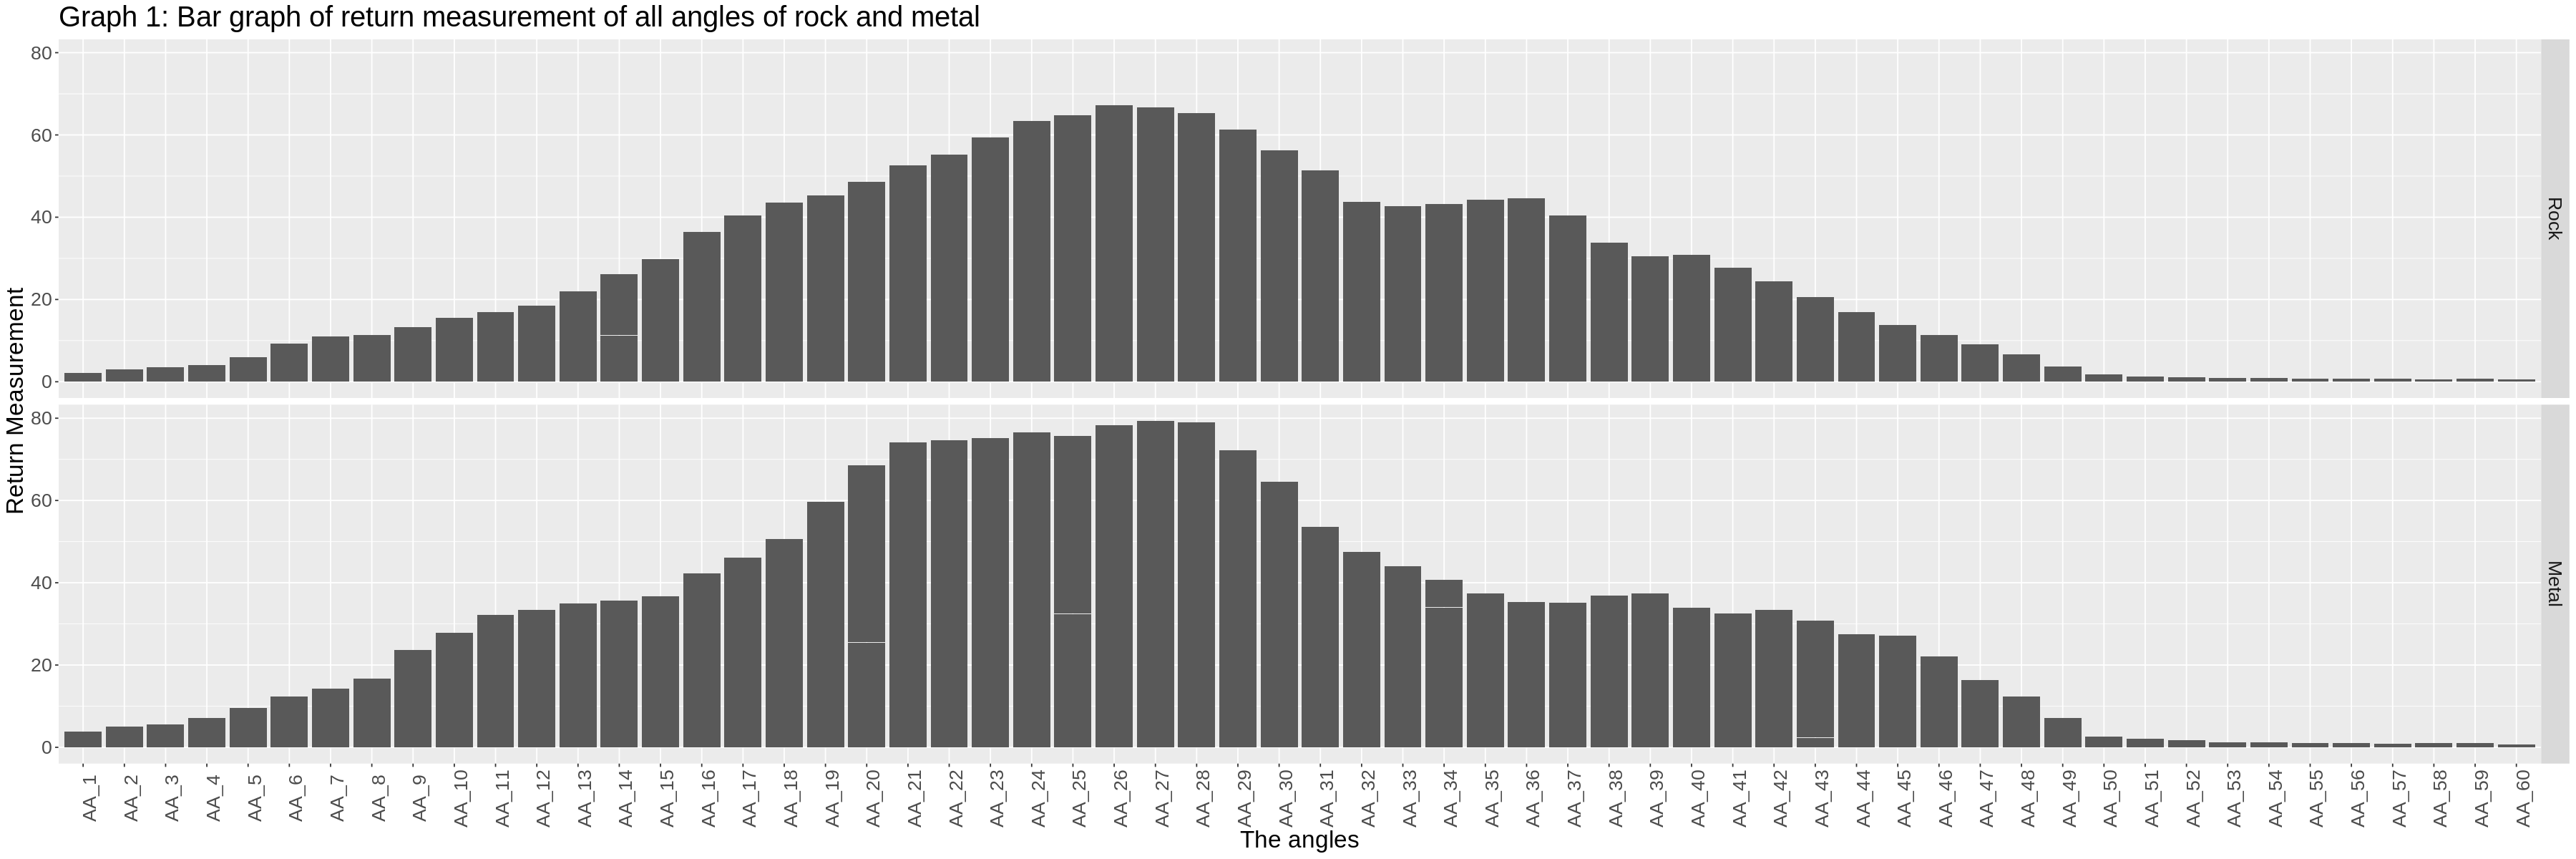

In [19]:
# Set size of plots
options(repr.plot.width = 30, repr.plot.height = 10)

# Tidy data
sonar_longer <- pivot_longer(sonar,
            cols = AA_1:AA_60,
            names_to = "angle",
            values_to = "return_measurement") %>%
            # filter(angle == "AA_1" | angle == "AA_2" | angle == "AA_3" | angle == "AA_4" | angle == "AA_5") %>%
            mutate(angle = as_factor(angle)) %>%
            mutate(Rocks_or_Mines = recode(Rocks_or_Mines, R = "Rock", M = "Metal"))

# plot the distribution of return signals of rock and metal for all angles
# sonar_longer %>% ggplot(aes(x = return_measurement)) + 
#    geom_histogram(binwidth = 0.01) +
#    xlab("Sonar return signal") + 
#    ylab("Frequency") +
#    labs(title = "Graph 1: Distribution of return signals of rock and metal for first five angles") +
#    facet_grid(angle ~ Rocks_or_Mines, scales = "free",
#               switch = "y") +
#    theme(axis.text.x = element_text(angle = 90, hjust = 0.5),
#         strip.text.y.left = element_text(angle = 0),
#         text = element_text(size = 20))

# Plot a bar graph of return measurement of all angles of rock and metal
sonar_distrib_hist <- sonar_longer %>% ggplot(aes(x = angle, y = return_measurement)) +
    geom_bar(stat = "identity") +
    labs(x = "The angles", y = "Return Measurement", title = "Graph 1: Bar graph of return measurement of all angles of rock and metal") +
    facet_grid(rows = vars(Rocks_or_Mines)) + 
    theme(axis.text.x = element_text(angle = 90, hjust = 0.5),
        text = element_text(size = 20))
sonar_distrib_hist

According to Graph 1, XXXXXXXXXXXXXXXX.

### Data Analysis

To conduct the data analysis, we will use all the columns. Even though it is not ideal to use all the columns for data analysis in many cases, in our case the columns named AA_1 to AA_60 represent 60 different features used to identify whether the object that bounces of a chosen sonar signal a metal cylinder or a cylindrical rock. Each of these 60 features are equally important to discriminate between the sonar signals.


In order to choose the optimal K value for the KNN classification, we used cross-validation method.

The vfold_cv function splits the training data into 5 validation data sets. 

By calling the nearest_neighbor function, we create a model specification. The weight function specifies "rectangular" so that each of the K nearest neighbors gets exactly 1 vote. Rather than specifying a parciular value for neighobrs, they are tuned to identify the best K value. In the set_engine argument, kknn is the R package for performing KNN neighbors classification. Finally, we specify that this is a classification problem with the set_mode function.

Next, we create the recipe from the training data set, identifying the Rocks_or_Mines as the target variable and AA_1, AA_2, AA_3, AA_4, and AA_5 as the predictors. We also scale and cetner all the predictors to standardize the size of the sclae effects.

Then we create a data analysis workflow from the recipe and model we created earlier. We run the cross-validation and collect the information about the mean and standard error of the classifier’s validation accuracy across the folds. 

We identify the rows with accuracy value from ".metric" column and plot the graph the relationship between the estimated accuracies and K values(neighbors).

[1] "Table 5: Metrics with Accuracies"


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.8352419,5,0.01963459,Model01
4,accuracy,binary,0.7904704,5,0.02277025,Model02
5,accuracy,binary,0.7898522,5,0.02384489,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
11,accuracy,binary,0.6950672,5,0.03509797,Model08
13,accuracy,binary,0.6879839,5,0.02986204,Model09
14,accuracy,binary,0.6879839,5,0.02986204,Model10


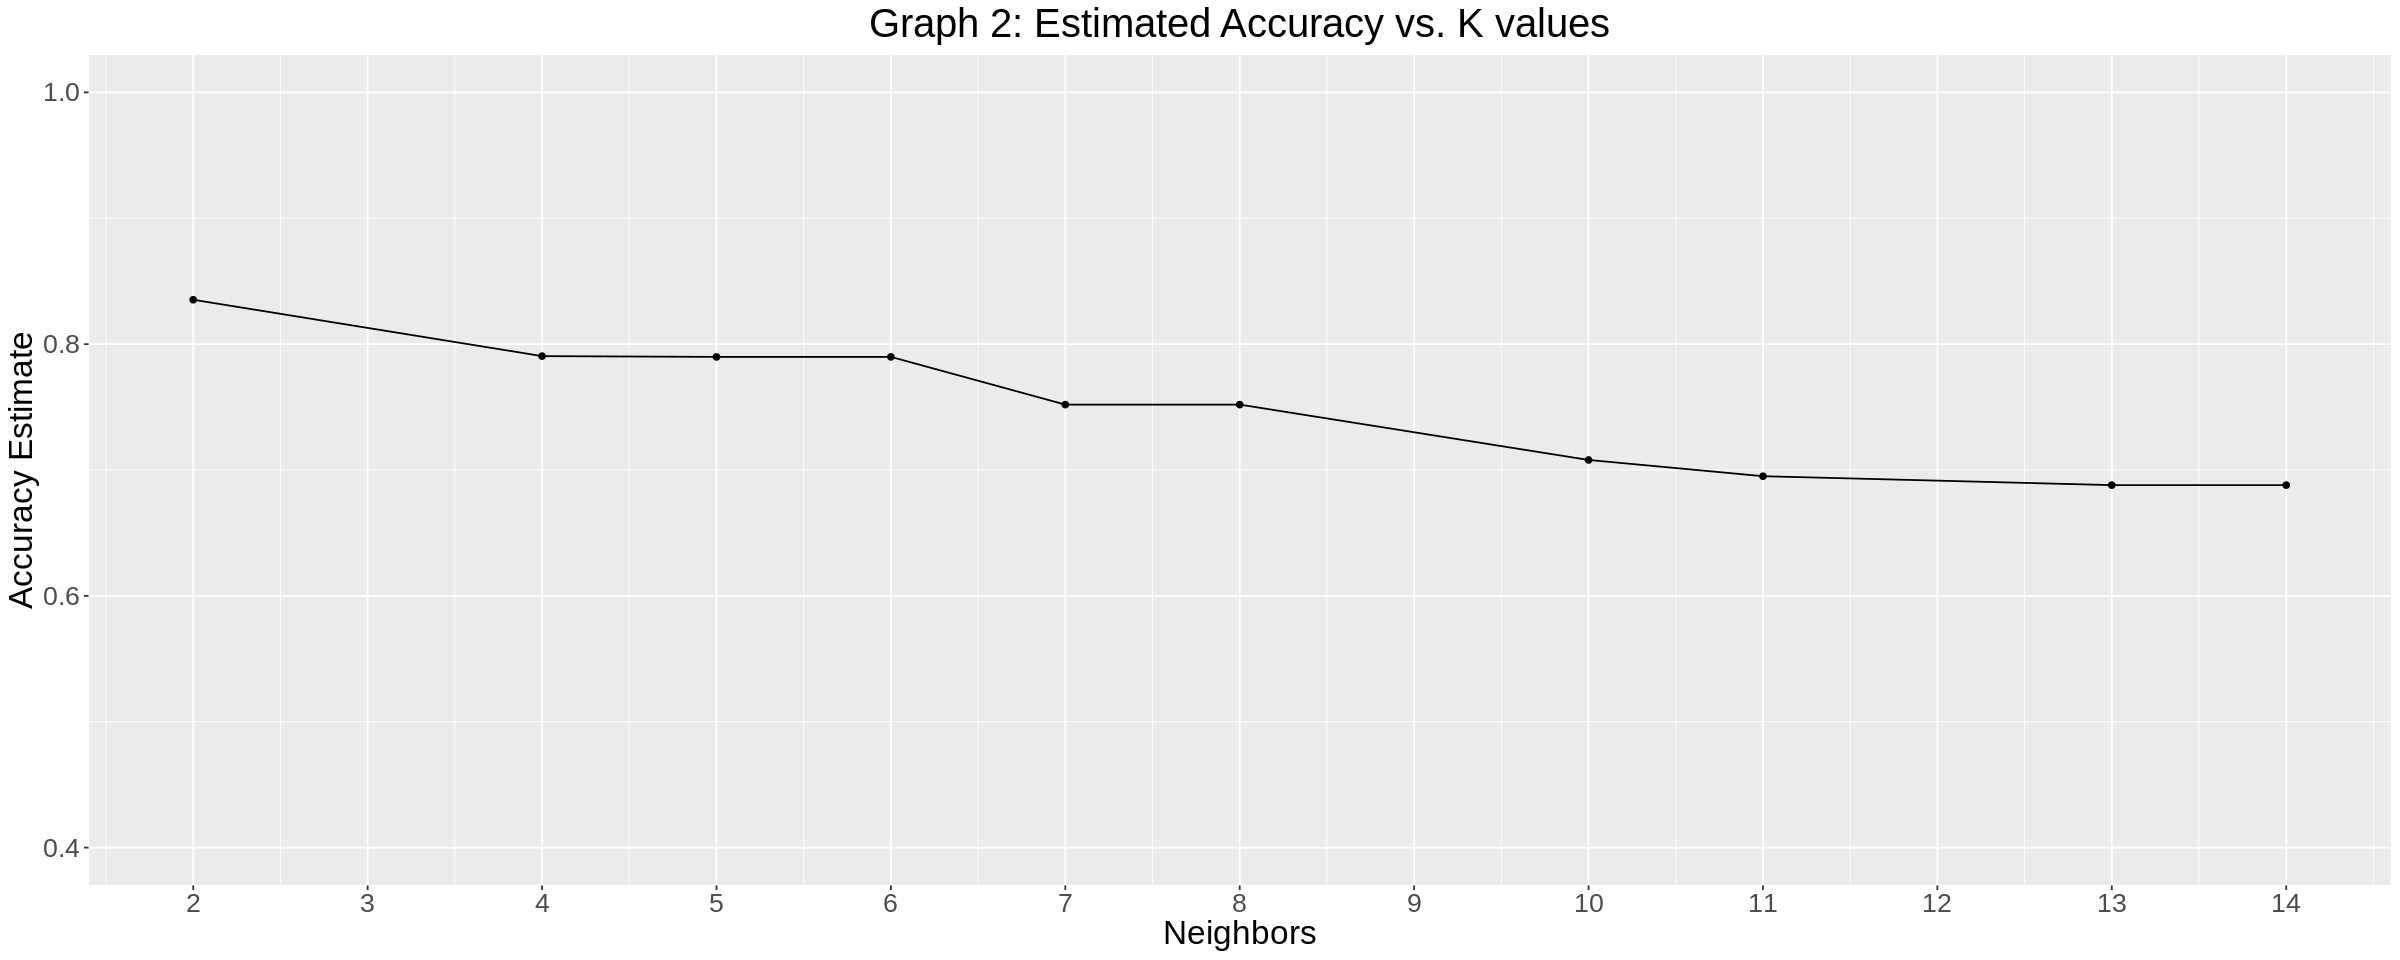

In [11]:
# Set the same seed
set.seed(2022)

# Perform 5-fold cross-validation
sonar_vfold <- vfold_cv(sonar_training, v = 5, strata = Rocks_or_Mines)

# create a model specification for K-nearest neighbors classification and set neighbors to tune
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

# Standardize all predictors by recipe
sonar_recipe <- recipe(Rocks_or_Mines ~., data = sonar_training) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

# Creat a workflow to find the best K value
knn_results <- workflow() %>%
    add_recipe(sonar_recipe) %>%
    add_model(knn_spec) %>%
    tune_grid(resamples = sonar_vfold, grid = 10) %>%
    collect_metrics()

# Select accuracy
accuracies <- knn_results %>%
    filter(.metric == "accuracy")
print("Table 5: Metrics with Accuracies")
accuracies

# Plot Estimated Accuracy verus K value(Neighbors) to find best k
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") + 
    ggtitle("Graph 2: Estimated Accuracy vs. K values") +
    scale_x_continuous(breaks = seq(0, 20, by = 1)) +
    scale_y_continuous(limits = c(0.4, 1.0)) +
    theme(plot.title = element_text(hjust = 0.5), 
          text = element_text(size = 20))

accuracy_vs_k

According Graph 2, we chose K = 2 as the optimal K value because it has the highest accuracy.
Now we recreate the KNN classification specification with K = 2 using the training data set and predict the Rocks_or_Mines in the testing data set. 

In [12]:
# Using the best K value to creat classification model
sonar_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) %>% 
    set_engine("kknn") %>%
    set_mode("classification")

# Creat the fit model for the best K value
sonar_fit <- workflow() %>%
    add_recipe(sonar_recipe) %>%
    add_model(sonar_spec) %>%
    fit(data = sonar_training)

# Using model to predict testing data
sonar_test_predictions <- predict(sonar_fit, sonar_testing) %>%
    bind_cols(sonar_testing)
print("Table 6: Prediction of Sonar Testing Data Set")
sonar_test_predictions

# Compute prediction accuracy
sonar_prediction_accuracy <- sonar_test_predictions %>%
    metrics(truth = Rocks_or_Mines, estimate = .pred_class) %>%
    filter(.metric == "accuracy")
print("Table 7: Prediction Accuracy")
sonar_prediction_accuracy

# Find confusion matrix of Rocks and Mines
confusion <- sonar_test_predictions %>%
    conf_mat(truth = Rocks_or_Mines, estimate = .pred_class)
print("Table 8: Confusion Matrix of Rocks and Mines")
confusion

[1] "Table 6: Prediction of Sonar Testing Data Set"


.pred_class,AA_1,AA_2,AA_3,AA_4,AA_5,AA_6,AA_7,AA_8,AA_9,⋯,AA_52,AA_53,AA_54,AA_55,AA_56,AA_57,AA_58,AA_59,AA_60,Rocks_or_Mines
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
R,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,⋯,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
R,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,⋯,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
R,0.0039,0.0063,0.0152,0.0336,0.0310,0.0284,0.0396,0.0272,0.0323,⋯,0.0062,0.0120,0.0052,0.0056,0.0093,0.0042,0.0003,0.0053,0.0036,R
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
M,0.0323,0.0101,0.0298,0.0564,0.0760,0.0958,0.0990,0.1018,0.1030,⋯,0.0061,0.0093,0.0135,0.0063,0.0063,0.0034,0.0032,0.0062,0.0067,M
M,0.0522,0.0437,0.0180,0.0292,0.0351,0.1171,0.1257,0.1178,0.1258,⋯,0.0160,0.0029,0.0051,0.0062,0.0089,0.0140,0.0138,0.0077,0.0031,M
M,0.0303,0.0353,0.0490,0.0608,0.0167,0.1354,0.1465,0.1123,0.1945,⋯,0.0086,0.0046,0.0126,0.0036,0.0035,0.0034,0.0079,0.0036,0.0048,M


[1] "Table 7: Prediction Accuracy"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9019608


[1] "Table 8: Confusion Matrix of Rocks and Mines"


          Truth
Prediction  R  M
         R 21  2
         M  3 25

From the Table 7, the accuracy is around 90%, meaning the model is doing great.

### Visualization of Data Analysis

Since we have a large number of features, one way we will use to visualize our results is by using a Principal Component Analysis (PCA) plot. A PCA plot is the analysis of the linear components of all existing attributes of a data set and it is primarily used to better visualize the variations present in a dataset with many variables.

## Expected Outcomes and Significance

We expect that there is some clustering pattern with sonar measurements and a KNN clustering model should be able to reasonably predict if an unknown object is metal or rock given a vector of 60 sonar measurements.


Predicting the object's material from sonar measurements is usually done by humans. The findings listed above could show that this process can be automated and perhaps be done with higher accuracy.


This dataset only has metal and rock as object categories. It would be interesting to see if clustering model could be applied to a larger range of material types.

The clustering model will have an accuracy. It would also be interesting to see if other types of predictive models could be trained to have a higher accuracy.